In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import product
import math

### Helper Functions

In [2]:
def conv2(F, W, PAD, grey=False):
    '''
    Computes the 2D convolution of a kernel with an image. Automatically pads
    accoriding to the kernel dimensions to maintain the original images size.
    If the image is 3D, computes the 2D convolution accross each channel seperately.

    Args:
        F: image to filter/convolute, specified as either
             - a string containing the path to the image
             - a np.ndarrary
        W: kernel to convolute across image
             - np.ndarray of 2D filter weights
        PAD: padding type to be applied to image.
             - Clip: zero padding
             - wrap: wraps the opposite edge over
             - edge: copies the edge pixels
             - reflect: refelcts the pixels across the edge
        grey: Specifies if F is to be read as a greyscale image
             - Default value is False
             - Pass true to return a greyscale image
    '''
######################## Preprocessing ########################
    # Check if image or debug array
    image = False
    if isinstance(F, str):
        if grey: F = cv2.imread(F, cv2.IMREAD_GRAYSCALE)
        else: F = cv2.imread(F)
        image = True

    # Get image basics
    FSize = F.shape
    RGB = False
    if F.ndim > 2:
        RGB = True
        
    if W.ndim == 1:
        W = W.reshape(1,W.shape[0])
    if W.ndim > 2:
        WRows = W.shape[1]
        WColumns = W.shape[2]
    else:
        WRows = W.shape[0]
        WColumns = W.shape[1]

    # Create kernel class
    class KernelObj():
        def __init__(self, W):
            self.rDim = WRows
            self. cDim = WColumns
            self.weights = W.flatten()
            self.padSizes()
            self.setRefPix()
            self.pixels = list(product(range(0,self.rDim), range(0,self.cDim)))

        # Get padding dimensions
        def padSizes(self):
            # Image padding & set refpix
            self.rPadBSize = int(np.floor(self.rDim / 2)) # padding width on rows
            self.cPadRSize = int(np.floor(self.cDim / 2)) # padding width on columns
            if self.rDim % 2 == 0: # if rows even
                self.rPadTSize = int(self.rDim/2 - 1)
            else: # if rows odd
                self.rPadTSize = self.rPadBSize
            if self.cDim % 2 == 0: # if columns even
                self.cPadLSize = int(self.cDim/2 - 1)
            else: # if columns odd
                self.cPadLSize = self.cPadRSize
        
        # Set starting reference pixel coordinate
        def setRefPix(self):
            if self.rDim % 2 == 0: # if rows even
                refpixR = int(self.cDim/2 - 1)
            else: # if rows odd
                refpixR = int((self.cDim + 1)/2 - 1)
            if self.cDim % 2 == 0: # if columns even
                refpixC = int(self.cDim/2 - 1)
            else: # if columns odd
                refpixC = int((self.cDim + 1)/2 - 1)
            self.refpix = (refpixR, refpixC)

        # Slides kernel 1 column to the right
        def slide(self):
            self.refpix = (self.refpix[0], self.refpix[1] + 1)
            self.pixels = [(pixel[0], pixel[1] + 1) for pixel in self.pixels]

        # Moves kernel to next row down
        def nextrow(self,i):
            # Reset refpix and pixels
            self.setRefPix()
            self.refpix = (self.refpix[0] + i, self.refpix[1])
            self.pixels = list(product(range(i, self.rDim + i), range(0, self.cDim)))

    # Create kernel instance    
    kernel = KernelObj(W)

######################## Pad image ########################
    match PAD:
        case 'clip':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='constant', constant_values=0)
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='constant', constant_values=0)
        case 'wrap':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='wrap')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='wrap')
        case 'edge':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='edge')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='edge')
        case 'reflect':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='symmetric')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='symmetric')

######################## Convolution ########################
    # Output of convolution
    outputF = np.zeros(FSize)

    if RGB:
        channels = 3
        # Iterate through original F size but operate on paddedF
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                for channel in range(0,channels):
                    singleChannelPaddedF = paddedF[:,:,channel]
                    # Convolve kernel with windowed pixels in paddedF
                    rPixels, cPixels = zip(*kernel.pixels)
                    windowedPixels = singleChannelPaddedF[rPixels, cPixels]
                    #windowedPixels = windowedPixels.reshape(kernel.rDim, kernel.cDim)
                    convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                    # Store output in resulting image
                    outputF[row, column, channel] = convOutput
                    
                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)
    else:
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                # Convolve kernel with windowed pixels in paddedF
                rPixels, cPixels = zip(*kernel.pixels)
                windowedPixels = paddedF[rPixels, cPixels]
                convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                # Store output in resulting image
                outputF[row,column] = convOutput

                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)

    # Normalize and convert    min = np.min(outputF)
    min = np.min(outputF)
    # max = np.max(outputF)
    outputF = (outputF - min) / (255 - min) * 255
    outputF = outputF.astype(np.uint8)
    
    #if image: outputF = Image.fromarray(outputF)
    if image and RGB: 
        outputF = cv2.cvtColor(outputF, cv2.COLOR_BGR2RGB)
        paddedF = cv2.cvtColor(paddedF, cv2.COLOR_BGR2RGB)

    return outputF, paddedF

def upsample(IMAGE, SCALE=2):
    #upsampled_image = cv2.resize(IMAGE, (2*IMAGE.shape[0], 2*IMAGE.shape[1]), interpolation=cv2.INTER_NEAREST)
    upsampled_image = cv2.pyrUp(IMAGE)
    '''
    # Create upscaled image
    grey = False
    if len(IMAGE.shape) == 2:
        grey = True
        IMAGE = np.expand_dims(IMAGE, axis=2)
    upscaled_size = (IMAGE.shape[0]*SCALE, IMAGE.shape[1]*SCALE, IMAGE.shape[2])
    upscaled_image = np.zeros(upscaled_size)

    # Loop through every pixel in each channel
    for idx, channel in enumerate(upscaled_image.transpose(2, 0, 1)):
        for r in range(upscaled_size[0]):
            for c in range(upscaled_size[1]):
                # Find nearest neighbor coordinates
                original_r = min(r // SCALE, IMAGE.shape[0] - 1)
                original_c = min(c // SCALE, IMAGE.shape[1] - 1)

                # Assign new pixel with nearest neighbor
                channel[r,c] = IMAGE[original_r,original_c,idx]
        upscaled_image[:,:,idx] = channel
    if grey:
        upscaled_image = np.squeeze(upscaled_image, -1)
    '''
    return upsampled_image

def normalize(INPUT, SCALE=1):
    # If input is a pyramid
    if isinstance(INPUT, list):
        # Get absolute max and min of all levels
        max, min = 1, 0
        for level in INPUT:
            levelMax = np.max(level)
            levelMin = np.min(level)
            if levelMax > max:
                max = levelMax
            if levelMin < min:
                min = levelMin
        # Now normalize each level
        for levelIdx, level in enumerate(INPUT):
            # Convert to float
            level = level.astype(float)
            # Work in 3D
            grey = False
            if len(level.shape) == 2:
                grey = True
                level = np.expand_dims(level, axis=2)
            # Iterate through channels
            for idx, channel in enumerate(level.transpose(2, 0, 1)):
                # Edge case
                if np.max(channel) == 0:
                    continue
                # Normalize (max will always be 255)
                else:
                    channel = (channel - min)/(max - min)
                # Assign channel to level
                level[:,:,idx] = channel
            # Assign level to pyramid
            INPUT[levelIdx] = level
            if grey:
                level = np.squeeze(level, -1)


    # If input is just an image
    else:
        INPUT = INPUT.astype(float)
        # Work in 3D
        grey = False
        if len(INPUT.shape) == 2:
            grey = True
            INPUT = np.expand_dims(level, axis=2)
        # Iterate through every channel
        for idx, channel in enumerate(INPUT.transpose(2, 0, 1)):
            # Edge case
            if np.max(channel) == 0:
                continue
            # Normalize
            else:
                channel = ((channel - np.min(channel)) / (np.max(channel) - np.min(channel))) * SCALE
            INPUT[:,:,idx] = channel
        if grey:
            INPUT = np.squeeze(INPUT, -1)

    return INPUT

In [3]:
sun = cv2.imread("sun.jpg")
sun = cv2.cvtColor(sun, cv2.COLOR_BGR2RGB)
moon = cv2.imread("moon.jpg")
moon = cv2.cvtColor(moon, cv2.COLOR_BGR2RGB)

(512, 512, 3)


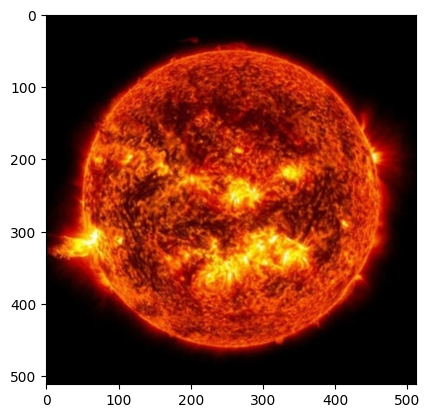

In [4]:
plt.imshow(sun)
print(sun.shape)

(512, 512, 3)


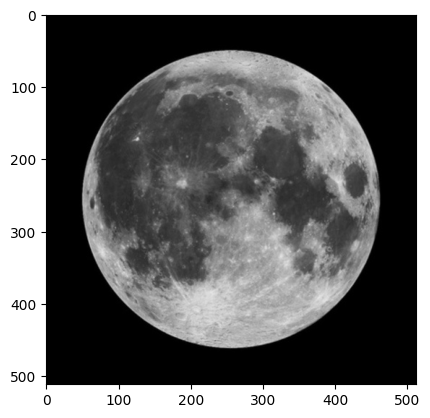

In [5]:
plt.imshow(moon)
print(moon.shape)

# Part A

In [6]:
def gaussian_pyramid(IMAGE, NUMLEVELS):
    G = IMAGE.copy()
    gp = [G]
    for i in range(1,NUMLEVELS):
        G = cv2.pyrDown(G)
        gp.append(G)
    return gp

def laplacian_pyramid(GP):
    numLevels = len(GP)-1
    lp  = [GP[numLevels]]
    for i in range(numLevels,0,-1):
        GE = cv2.pyrUp(GP[i])
        L = cv2.subtract(GP[i-1],GE)
        lp.append(L)
    lp = lp[::-1]
    return lp

# Pyramid levels
levels = 6
'''
gpSun = gaussian_pyramid(sun,levels)
lpSun = laplacian_pyramid(gpSun)

gpMoon = gaussian_pyramid(moon,levels)
lpMoon = laplacian_pyramid(gpMoon)

lena = cv2.imread("lena.png")
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
gpLena = gaussian_pyramid(lena,levels)
lpLena = laplacian_pyramid(gpLena)
'''

'\ngpSun = gaussian_pyramid(sun,levels)\nlpSun = laplacian_pyramid(gpSun)\n\ngpMoon = gaussian_pyramid(moon,levels)\nlpMoon = laplacian_pyramid(gpMoon)\n\nlena = cv2.imread("lena.png")\nlena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)\ngpLena = gaussian_pyramid(lena,levels)\nlpLena = laplacian_pyramid(gpLena)\n'

### Part A Henry Version

In [7]:
def Get_2D_Gaussian_kernel(kernel_size,sigma):
    #Kernel_size should be an odd integer
    #sigma is the standard deviation of the Gaussian
    # Generate 1D Gaussian kernel
    kernel_1d = cv2.getGaussianKernel(kernel_size, sigma)
    # Create a 2D Gaussian kernel by multiplying the 1D kernel with its transpose
    kernel_2d = kernel_1d @ kernel_1d.T
    return(kernel_2d)    


def ComputePyr(input_image, num_layers):
    #check if num_layers is valid
    num_layers = num_layers - 1
    #find max layers from computing how many times the smallest dimension can be divided by two, add one for the base layer
    max_layers = np.log2(min(input_image.shape[:2]))
    max_layers = math.floor(max_layers)
    if num_layers > max_layers:
        num_layers = max_layers
    #create the guassian kernel used to create the pyramid
    kernel_size = 5
    sigma = np.sqrt(2)
    #Gaussian_Kernel = (1/256)*np.array([[1,2,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[1,4,6,4,1]])
    Gaussian_Kernel = Get_2D_Gaussian_kernel(kernel_size,sigma)
    #initialize the gaussian pyramid  with the first layer as the original image
    gPyr = [input_image]
    #initialize conditions for the loop to create the gaussian pyramid
    current_image = input_image
    #loop to create the Gaussian Pyramid
    for layer in range(num_layers): #iterates num_layers - 1 times
        #blur the image
        blurred_image = conv2(current_image,Gaussian_Kernel,"reflect across edge")
        #use nearest neighbor downsampling
        height, width = blurred_image.shape[:2]
        current_image = cv2.resize(blurred_image, (width // 2, height // 2), interpolation=cv2.INTER_NEAREST)
        #add the downsampled image to the pyramid
        gPyr.append(current_image)

    #make laplcian pyramid
    lPyr = [] #create an empty list
    for layer in range(num_layers): #iterates max_layers - 1 times
        #upsample each layer
        upscaled_image = cv2.resize(gPyr[layer+1], (gPyr[layer].shape[1],gPyr[layer].shape[0]), interpolation=cv2.INTER_NEAREST) #doubles the dimensions and upscales using nearest neighbor method
        #subtract upsampled image from the next highest level from the current layer
        lPyr.append(np.maximum(gPyr[layer] - upscaled_image,0))
    #last level of lPyr is the last level of gPyr since there is no higher level to upsample
    lPyr.append(gPyr[num_layers])    

    return gPyr, lPyr

def conv2(f,w,pad): #f = input image, w = 2-D kernel filter, pad = the 4 padding types 

    def pad_gray_image(f,padding_width,pad):
        #np.pad(array,pad_width,mode)
        match pad:
            case 'zero padding':
                return np.pad(f,pad_width = padding_width,mode='constant',constant_values = 0)
            case 'wrap around':
                return np.pad(f,pad_width = padding_width,mode='wrap')
            case 'copy edge':
                return np.pad(f,pad_width = padding_width,mode='edge')
            case 'refelct across edge':
                return np.pad(f,pad_width = padding_width,mode='reflect')
    
    def pad_RGB_image(f,padding_width,pad):
        #np.pad(array,pad_width,mode)
        padding = ((padding_width,padding_width),(padding_width,padding_width),(0,0))
        match pad:
            case 'zero padding':
                return np.pad(f,padding,mode='constant',constant_values = 0)
            case 'wrap around':
                return np.pad(f,padding,mode='wrap')
            case 'copy edge':
                return np.pad(f,padding,mode='edge')
            case 'reflect across edge':
                return np.pad(f,padding,mode='reflect')
        
    def convolution_range(dimension_length):
        if dimension_length % 2 == 0: #(value is even)
            convolve_min = int(-dimension_length/2 +1)
            convolve_max = int(dimension_length/2)
        else:
            convolve_min = int(-(dimension_length-1)/2)
            convolve_max = int((dimension_length-1)/2)
        return convolve_min, convolve_max
    
    #step 0 get appropriate padding size based on kernel
    padding_dimension = max(w.shape)
    padding_size = padding_dimension // 2 

    #step 1 determine if its grayscale or RGB
    #if grayscale
    if len(f.shape) == 2:
        #step2 pad the image
        padded_image = pad_gray_image(f,padding_size,pad) #since we are only using up to a 3x3 kernel we can pad all images by 1 on each side
        height,width = f.shape #get original image dimensions
        g = np.zeros((height,width)) #make an array of the same dimesions to be filled for the output image
        k_height, k_width = w.shape #get the height and width of the kernel
        height_convolve_min, height_convolve_max = convolution_range(k_height)
        width_convolve_min, width_convolve_max = convolution_range(k_width)
        kernel_height_center = int((height_convolve_max-height_convolve_min)/2 - ((height_convolve_max-height_convolve_min) % 2))
        kernel_width_center = int((width_convolve_max-width_convolve_min)/2 - ((width_convolve_max-width_convolve_min) % 2))
        for u in range(padding_size,height+padding_size): #plus one because images are padded by one on each side
            for v in range(padding_size,width+padding_size):
                convolution_value = 0
                for k_u in range(height_convolve_min,height_convolve_max+1):
                    for k_v in range(width_convolve_min,width_convolve_max+1):
                        convolution_value = convolution_value + padded_image[(u+k_u),(v+k_v)]*w[(kernel_height_center+k_u),(kernel_width_center+k_v)]
                g[(u-padding_size),(v-padding_size)] = convolution_value

    #if RGB
    elif len(f.shape) == 3:
        #step 2 pad the image
        padded_image = pad_RGB_image(f,padding_size,pad)
        height,width = f.shape[:2] #get original image dimensions
        g = np.zeros((height,width,3)) #make an array of the same dimesions to be filled for the output image
        k_height, k_width = w.shape #get the height and width of the kernel
        height_convolve_min, height_convolve_max = convolution_range(k_height)
        width_convolve_min, width_convolve_max = convolution_range(k_width)
        kernel_height_center = int((height_convolve_max-height_convolve_min)/2 - ((height_convolve_max-height_convolve_min) % 2))
        kernel_width_center = int((width_convolve_max-width_convolve_min)/2 - ((width_convolve_max-width_convolve_min) % 2))
        for channel in range(0,3):
            for u in range(padding_size,height+padding_size): #plus one because images are padded by one on each side
                for v in range(padding_size,width+padding_size):
                    convolution_value = 0
                    for k_u in range(height_convolve_min,height_convolve_max+1):
                        for k_v in range(width_convolve_min,width_convolve_max+1):
                            convolution_value = convolution_value + padded_image[(u+k_u),(v+k_v),channel]*w[(kernel_height_center+k_u),(kernel_width_center+k_v)]
                    g[(u-padding_size),(v-padding_size),channel] = convolution_value        
    #step 3 change the image values from float 64s back to uint8 
    #we need to normalize the values to 0 through 255
    '''
    max_value = np.max(g)
    min_value = np.min(g)
    g_range = max_value-min_value
    g = (g-min_value)/g_range
    g = (255*g).astype(np.uint8)
    '''

    return g

In [8]:
#_, lpSun = ComputePyr(sun,6)
#_, lpMoon = ComputePyr(moon,6)

### Part A AJ Version

In [9]:
def getPyramids(input_image, num_layers):
    #check if num_layers is valid
    max_layers = np.log2(min(input_image.shape[:2]))
    max_layers = math.floor(max_layers)
    if num_layers > max_layers:
        num_layers = max_layers
    
    # Define gaussian kernel
    gaussian_kernel = (1/256)*np.array([[1,2,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[1,4,6,4,1]])

    # Gaussian pyramid function
    def gaussianPyramid(IMAGE, NUMLAYERS):
        gPyramid = [IMAGE]
        for i in range(0,NUMLAYERS-1):
            if input_image.dtype == np.float64:
                layer = gPyramid[i].astype(np.float64)
            else:
                layer = gPyramid[i].astype(np.float64)
            height, width = layer.shape[:2]
            if input_image.dtype == np.float64:
                blurred_layer = conv2(layer, gaussian_kernel, "reflect across edge").astype(np.float64)
            else:
                blurred_layer = conv2(layer, gaussian_kernel, "reflect across edge")
            gPyramid.append(cv2.resize(blurred_layer, (width // 2, height // 2), interpolation=cv2.INTER_NEAREST))
        return gPyramid
    
    # Laplacian pyramid function
    def laplacianPyramid(GPYRAMID):
        NUMLAYERS = len(GPYRAMID)
        lPyramid = [GPYRAMID[NUMLAYERS-1]]
        for i in range(NUMLAYERS-1,0,-1):
            layer = GPYRAMID[i]
            height, width = layer.shape[:2]
            upsampled_layer = cv2.resize(layer, (2*width, 2*height), interpolation=cv2.INTER_NEAREST)
            lPyramid.append(cv2.subtract(GPYRAMID[i-1],upsampled_layer))
        lPyramid = lPyramid[::-1]
        return lPyramid
    
    # Call functions to generate pyramids
    gPyr = gaussianPyramid(input_image,num_layers)
    lPyr = laplacianPyramid(gPyr)

    return gPyr, lPyr


In [10]:
#gpSunAJ, lpSunAJ = getPyramids(sun,6)
#gpMoonAJ, lpMoonAJ = getPyramids(moon,6)

# Part B

In [11]:
maskBig = np.concatenate((np.ones((512,256,3)),np.zeros((512,256,3))), axis=1)
#plt.imshow(maskBig)

gpMaskBig = gaussian_pyramid(maskBig,levels)
#plt.imshow(maskBig)

#gpMaskBigHenry, _ = ComputePyr(maskBig,6)

## Red Blue Test

In [12]:
red = np.full((8,8,3), 255, dtype='uint8')
red[:,0:1,0] = np.zeros((8,1))
red[:,:,1] = np.zeros((8,8))
red[:,:,2] = np.zeros((8,8))
red = red.astype(np.float64)

blue = np.full((8,8,3), 255, dtype='uint8')
blue[:,7:,2] = np.zeros((8,1))
blue[:,:,0] = np.zeros((8,8))
blue[:,:,1] = np.zeros((8,8))
blue = blue.astype(np.float64)

#plt.imsave("red.png", red)
#plt.imsave("blue.png", blue)

gpRed = gaussian_pyramid(red,3)
lpRed = laplacian_pyramid(gpRed)
gpBlue = gaussian_pyramid(blue,3)
lpBlue = laplacian_pyramid(gpBlue)

_, lpRedHenry = ComputePyr(red,3)
_, lpBlueHenry = ComputePyr(blue,3)

#gpRedAJ, lpRedAJ = getPyramids(red,3)
#gpBlueAJ, lpBlueAJ = getPyramids(blue,3)
'''
for i, img in enumerate(gpRedAJ):

    # Display the image
    plt.figure(figsize=(5, 5))
    #plt.imshow(img)
    plt.imshow(img, cmap='gray') #use if image is grayscale
    plt.title(f"Gaussian Level: {i}")
    plt.axis('off')  # Turn off axes
    plt.show()

for i, img in enumerate(lpRedAJ):

    # Display the image
    plt.figure(figsize=(5, 5))
    #plt.imshow(img)
    plt.imshow(img, cmap='gray') #use if image is grayscale
    plt.title(f"Laplacian Level: {i}")
    plt.axis('off')  # Turn off axes
    plt.show()
'''
maskSmall = np.concatenate((np.ones((8,4,3)),np.zeros((8,4,3))), axis=1)
gpMaskSmall = gaussian_pyramid(maskSmall,3)
gpMaskSmallHenry, _ = ComputePyr(maskSmall,3)
#pMaskSmallAJ, _ = getPyramids(maskSmall,3)
#gpMaskBigAJ, _ = getPyramids(maskBig,6)

# Part C

In [13]:
def laplacian_blend(SOURCE_LP, TARGET_LP, MASK_GP):
    # Number of pyramid levels
    numLevels = len(MASK_GP)

    # Normalize images but not mask
    SOURCE_LP = normalize(SOURCE_LP,255)
    TARGET_LP = normalize(TARGET_LP,255)
    MASK_GP = normalize(MASK_GP,1)

    # Create blended pyramid
    blended_pyramid = [MASK_GP[0]*SOURCE_LP[0] + (1-MASK_GP[0])*TARGET_LP[0]]
    for i in range(1,numLevels):
        blended_pyramid.append(MASK_GP[i]*SOURCE_LP[i] + (1-MASK_GP[i])*TARGET_LP[i])
    
    # Collapse the blended pyramid

    scale = 2
    for i in range(numLevels-1,0,-1):
        level = blended_pyramid.pop()
        level = upsample(level,scale)
        blended_pyramid[i-1] = cv2.add(blended_pyramid[i-1], level)
        #blended_pyramid[i-1] = blended_pyramid[i-1] + level
    blended_image = blended_pyramid[0]

    '''
    # now reconstruct
    ls_ = blended_pyramid[5]
    for i in range(4,-1,-1):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, blended_pyramid[i])
    blended_image = ls_
    '''
    # Normalize blended image to 0-255
    blended_image = normalize(blended_image, 255).astype(np.uint8)
    
    return blended_image

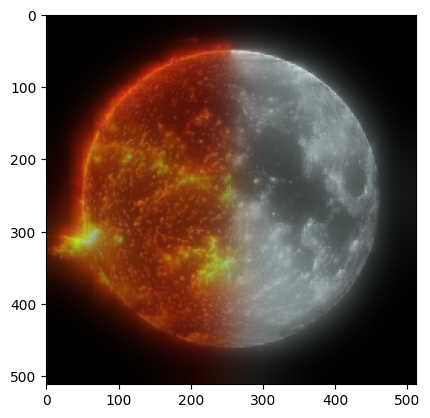

In [15]:
#blended_image = laplacian_blend(lpRedHenry,lpBlueHenry,gpMaskSmallHenry)
gpMaskBig,_ = ComputePyr(maskBig,6)
_, lpsun = ComputePyr(sun,6)
_, lpmoon = ComputePyr(moon,6)
blended_image = laplacian_blend(lpsun,lpmoon,gpMaskBig)
#blended_image = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)
plt.imshow(blended_image)